In [11]:
import onnxruntime as ort
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

In [6]:
class FloodModel:

    def __init__(self, model_path, verbose=False):
        self.model = ort.InferenceSession(model_path)
        self.input_name = self.model.get_inputs()[0].name
        self.output_name = self.model.get_outputs()[0].name
        self.verbose = verbose

        if self.verbose:
            print(f"Session initialized: {self.model}")

    def predict(self, image_path, output_path):
        image = Image.open(image_path).convert('RGB')
        image = self.preprocess_image(image)
        result = self.model.run([self.output_name], {self.input_name: image})

        if self.verbose:
            print("Shape of the result: ", result[0].shape)
    
        # Remove batch and channel dimensions (squeeze to get shape (512, 512))
        mask = np.squeeze(result[0], axis=(0, 3))  # Removes batch and channel dimensions

        # Convert mask to an image and save it
        mask_img = Image.fromarray(np.uint8(mask * 255))  # Scale values if necessary

        mask_img.save(output_path)

        self.image_path = image_path
        self.output_path = output_path

        return result
    
    
    def preprocess_image(self, image): 
        """
        This function returns the pre-processed image as a NumPy array. 
        """
        # Take away the A from RGBA
        image = image.convert('RGB')

        # load image as a 32-bit floating point array 
        image_ary=np.asarray(image)
        image_ary=image_ary.astype(np.float32)
            
        # pre-processing
        image_ary=(image_ary-127.5)*(1/127.5)
        
        # the sample_resnet18 segmentation model requires the data to be in BGR format
        BGR=np.empty_like(image_ary)
        BGR[:, :, 0]=image_ary[:, :, 2]
        BGR[:, :, 1]=image_ary[:, :, 1]
        BGR[:, :, 2]=image_ary[:, :, 0]
        image_ary=BGR
        
        # convert array from h, w, c to 1, c, h, w
        image_ary=np.transpose(image_ary, [2, 0, 1])
        image_ary=np.expand_dims(image_ary, axis=0)

        if self.verbose:
            print("Image array shape: ", image_ary.shape)

        return image_ary
    
    def plot(self):
        # plot input, triton inference, and ground truth
        fig, ax=plt.subplots(1, 2, figsize=[20, 5], sharex=True, sharey=True)
        ax[0].imshow(plt.imread(self.image_path))
        ax[1].imshow(plt.imread(self.output_path))

        # set title
        ax[0].set_title('Input Image')
        ax[1].set_title('Inference')

        # remove ticks
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        
        

In [7]:
#TODO: don't forget to put the correct path to your trained model in onnx engine format!
model_path = './resnet18.onnx'
model = FloodModel(model_path, verbose=True)

Session initialized: <onnxruntime.capi.onnxruntime_inference_collection.InferenceSession object at 0x766d71f88730>


In [9]:
image_path = './data/canoas/tile_0_0.png'
output_path = './data/output_canoas/tile_0_0.png'
output = model.predict(image_path, output_path)

Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)


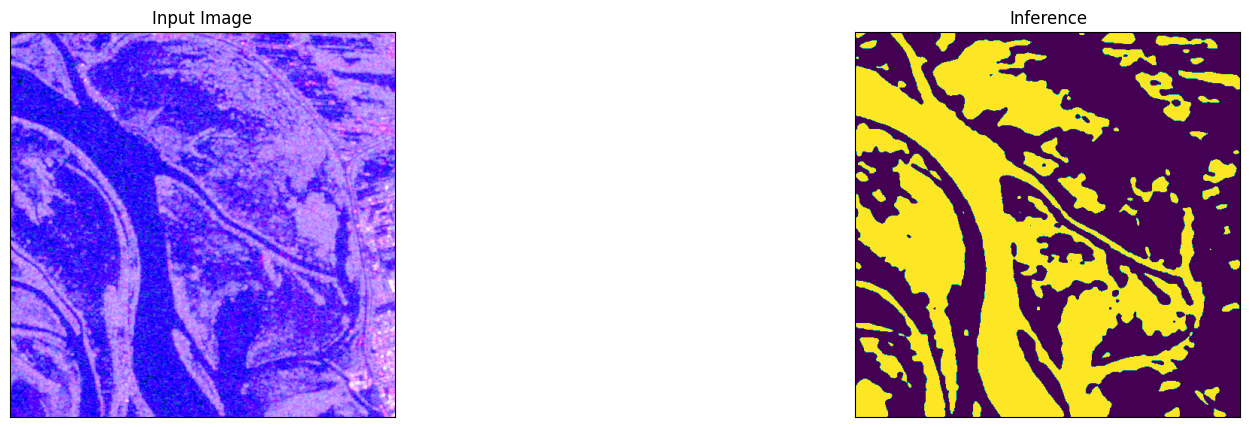

In [10]:
model.plot()

In [12]:
# Folder containing the images
input_folder = './data/canoas' 
output_folder = "./data/output_canoas"

for i in range(3):  # Assuming col represents the number of columns
    for j in range(3):  # Assuming row represents the number of rows
        filename = f"tile_{i}_{j}.png"
        model.predict(os.path.join(input_folder, filename), os.path.join(output_folder, filename))

Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)
Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)
Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)
Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)
Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)
Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)
Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)
Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)
Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)


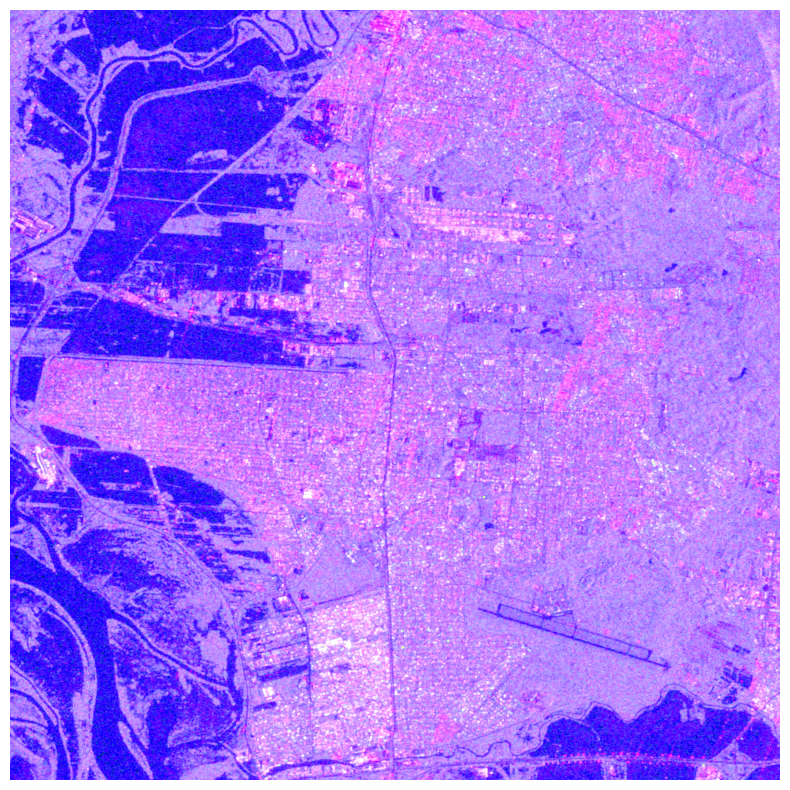

In [13]:
# Folder containing the images
folder_path = input_folder  # Ensure this variable is correctly named

# Load the images into a grid (row-wise)
tiles = []

for i in range(3):  # Assuming col represents the number of columns
    col_tiles = []
    for j in range(3):  # Assuming row represents the number of rows
        filename = f"tile_{i}_{j}.png"
        img = Image.open(os.path.join(folder_path, filename))
        col_tiles.append(img)
    tiles.append(col_tiles)

# Get the size of each tile (assuming all tiles are of the same size)
tile_width, tile_height = tiles[0][0].size

# Calculate the total width and height of the stitched image
full_width = 3 * tile_width  # Width should be based on columns
full_height = 3 * tile_height  # Height should be based on rows

# Create a blank image for the full grid
full_image = Image.new('RGB', (full_width, full_height))  # Use correct width and height

# Paste each row of images into the full image


x_offset = 0
for row_list in tiles:
    row_list.reverse()
    y_offset = 0
    for sing_img in row_list:
        full_image.paste(sing_img, (x_offset, y_offset))
        y_offset += tile_width
    x_offset += tile_height

# Convert the stitched image to a format suitable for plotting
full_image_np = np.array(full_image)

# Plot the stitched image
plt.figure(figsize=(10, 10))
plt.imshow(full_image_np)
plt.axis('off')  # Turn off the axis
plt.show()

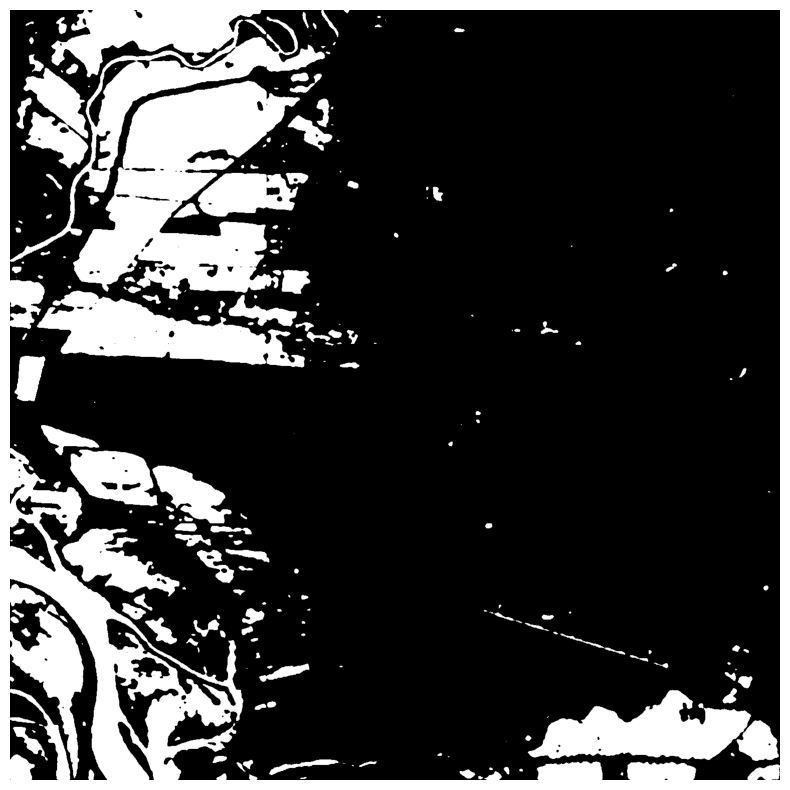

In [14]:
# Folder containing the images
folder_path = output_folder  # Ensure this variable is correctly named

# Load the images into a grid (row-wise)
tiles = []

for i in range(3):  # Assuming col represents the number of columns
    col_tiles = []
    for j in range(3):  # Assuming row represents the number of rows
        filename = f"tile_{i}_{j}.png"
        img = Image.open(os.path.join(folder_path, filename))
        col_tiles.append(img)
    tiles.append(col_tiles)

# Get the size of each tile (assuming all tiles are of the same size)
tile_width, tile_height = tiles[0][0].size

# Calculate the total width and height of the stitched image
full_width = 3 * tile_width  # Width should be based on columns
full_height = 3 * tile_height  # Height should be based on rows

# Create a blank image for the full grid
full_image = Image.new('RGB', (full_width, full_height))  # Use correct width and height

# Paste each row of images into the full image


x_offset = 0
for row_list in tiles:
    row_list.reverse()
    y_offset = 0
    for sing_img in row_list:
        full_image.paste(sing_img, (x_offset, y_offset))
        y_offset += tile_width
    x_offset += tile_height

# Convert the stitched image to a format suitable for plotting
full_image_np = np.array(full_image)

# Plot the stitched image
plt.figure(figsize=(10, 10))
plt.imshow(full_image_np)
plt.axis('off')  # Turn off the axis
plt.show()

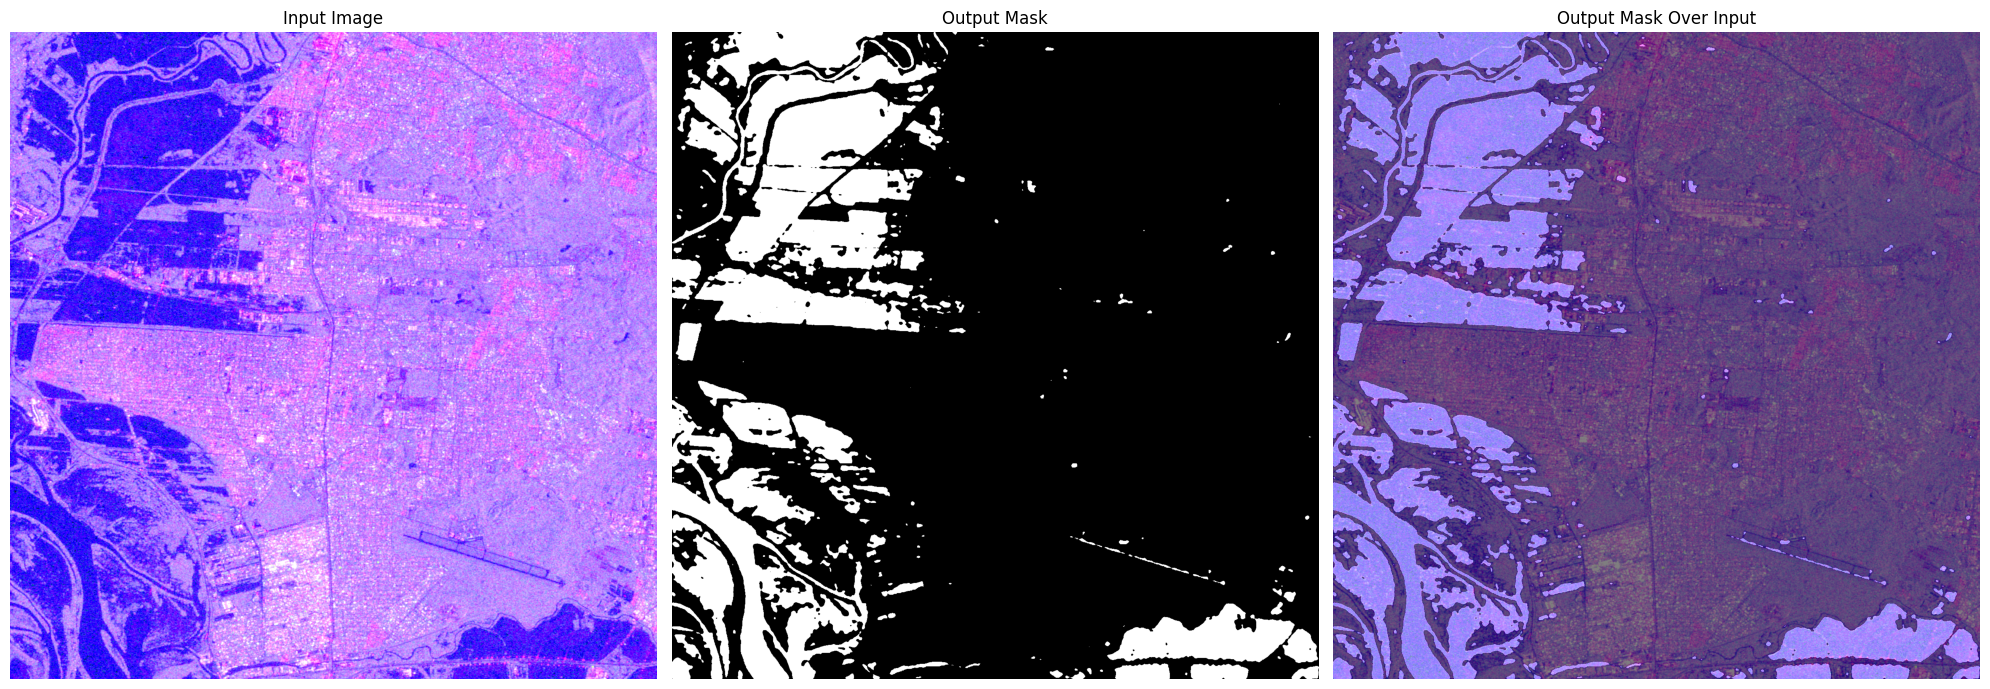

In [16]:
# Function to load images into a grid
def load_tiles(folder_path):
    tiles = []
    for i in range(3):  # Assuming col represents the number of columns
        col_tiles = []
        for j in range(3):  # Assuming row represents the number of rows
            filename = f"tile_{i}_{j}.png"
            img = Image.open(os.path.join(folder_path, filename))
            col_tiles.append(img)
        tiles.append(col_tiles)
    return tiles

# Function to stitch the images into a full grid
def stitch_images(tiles):
    tile_width, tile_height = tiles[0][0].size
    full_width = 3 * tile_width
    full_height = 3 * tile_height
    full_image = Image.new('RGB', (full_width, full_height))
    
    x_offset = 0
    for row_list in tiles:
        row_list.reverse()  # Adjust according to your layout needs
        y_offset = 0
        for sing_img in row_list:
            full_image.paste(sing_img, (x_offset, y_offset))
            y_offset += tile_width
        x_offset += tile_height
    return np.array(full_image)

# Load input and output tiles
input_tiles = load_tiles(input_folder)
output_tiles = load_tiles(output_folder)

# Stitch input and output images
input_image_np = stitch_images(input_tiles)
output_image_np = stitch_images(output_tiles)

# Create a composite image by overlaying the output mask on the input
# For overlay, we assume the output mask is grayscale or has a transparency channel
output_image_overlay = Image.fromarray(output_image_np).convert("RGBA")
input_image_overlay = Image.fromarray(input_image_np).convert("RGBA")

# Blend the images (adjust the alpha for transparency of the mask)
blended_image = Image.blend(input_image_overlay, output_image_overlay, alpha=0.5)

# Plot the input, output, and composite (overlaid) images
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

# Plot input image
axs[0].imshow(input_image_np)
axs[0].set_title('Input Image')
axs[0].axis('off')

# Plot output image
axs[1].imshow(output_image_np)
axs[1].set_title('Output Mask')
axs[1].axis('off')

# Plot blended image (output mask over input)
axs[2].imshow(np.array(blended_image))
axs[2].set_title('Output Mask Over Input')
axs[2].axis('off')

plt.tight_layout()
plt.show()